# Mesh refinement: time stepping for bidirectionally coupled solver

- COMSOL files are 02.MR.102.temporal_refinement.001 - 004 which are stored in /Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/02.MR.102.temporal_refinement.004_out.mph

In [57]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit

from scipy.stats import kde
from scipy import optimize

from matplotlib.ticker import NullFormatter
from matplotlib import pyplot, transforms
import matplotlib
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

pd.set_option("display.max_columns", 300)

In [58]:
# load temporal resolution data
data_folder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data/temporal_resolution/grid/'

# dataframe that contains the time stepping info
df_ts = pd.DataFrame({'run': ['001', '002', '003', '004'],
                     'ts': [2e-8, 2e-9, 2e-10, 2e-11]})

data = pd.DataFrame()

files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
# 02.MR.temporal_refinement.001.eNorm.csv
for file in files:
    run = re.findall(r'temporal_refinement\.(\d\d\d)\.eNorm', file)[0]
    data_tmp = pd.read_csv(f'{data_folder}/{file}', skiprows=8)
    
    # add ts info
    ts = df_ts[ df_ts['run'] == run ].loc[:,'ts'].values[0]
    data_tmp.columns = ['x','y', 'z', 'normE']
    data_tmp['run'] = run
    data_tmp['ts'] = ts 
    
#     print(data_tmp.head(10))
    data = data.append(data_tmp)

data

,x,y,z,normE,run,ts
0,-1.4,-1.4,-1.4,NaN,001,2.000000e-08
1,-0.9,-1.4,-1.4,NaN,001,2.000000e-08
2,-0.4,-1.4,-1.4,NaN,001,2.000000e-08
3,0.1,-1.4,-1.4,1.035313e+06,001,2.000000e-08
4,0.6,-1.4,-1.4,8.308442e+05,001,2.000000e-08
...,...,...,...,...,...,...
33070,69.6,1.4,1.4,2.882327e+06,004,2.000000e-11
33071,70.1,1.4,1.4,NaN,004,2.000000e-11
33072,70.6,1.4,1.4,NaN,004,2.000000e-11
33073,71.1,1.4,1.4,NaN,004,2.000000e-11


In [59]:
# remove NA columns
len_before = data.shape[0]
data = data.dropna()
print(f'Dropped {len_before - data.shape[0]} out of {len_before} rows with NAN values.')

Dropped 5354 out of 132300 rows with NAN values.


In [60]:
data = data.reset_index(drop=True)

In [61]:
# make sure the x, y, z are rounded to 2 decimals
cols_xyz = ['x', 'y', 'z']
data[cols_xyz] = data[cols_xyz].round(2)

In [62]:
# take only those rows of x,y,z where there is a value for all four runs

# group by each x y z
def check_each_xyz(df):
    # there must be four entries, otherwise add this to the list of combinations to delete
    if df.shape[0] < 4:
        return df
    else:
        pass

rows_to_delete = data.groupby(cols_xyz).apply(lambda x: check_each_xyz(x))
rows_to_delete = rows_to_delete[rows_to_delete.notnull().any(1)]
print(data.shape)
data = data.drop(rows_to_delete.index)
print(data.shape)

(126946, 6)
(126940, 6)


In [85]:
# group by xzy and calculate the difference in the electric field for those points relative to the finest time stepping
def calculate_difference(df):
    # reference normE
    E_ref = df[df['run'] == '004'].loc[:,'normE'].values[0]
    df['diff'] = df['normE'].apply(lambda x: np.abs(x-E_ref)) # just the difference

    return df

data_diff = data.groupby(cols_xyz).apply(lambda x: calculate_difference(x))
data_diff

,x,y,z,normE,run,ts,diff
0,0.1,-1.4,-1.4,1.035313e+06,001,2.000000e-08,11283.464446
1,0.6,-1.4,-1.4,8.308442e+05,001,2.000000e-08,2065.175785
2,1.1,-1.4,-1.4,8.109103e+05,001,2.000000e-08,406.083534
3,1.6,-1.4,-1.4,8.116171e+05,001,2.000000e-08,756.491043
4,2.1,-1.4,-1.4,8.171768e+05,001,2.000000e-08,228.736856
...,...,...,...,...,...,...,...
126941,67.6,1.4,1.4,2.628834e+06,004,2.000000e-11,0.000000
126942,68.1,1.4,1.4,2.687324e+06,004,2.000000e-11,0.000000
126943,68.6,1.4,1.4,2.749113e+06,004,2.000000e-11,0.000000
126944,69.1,1.4,1.4,2.813960e+06,004,2.000000e-11,0.000000


In [95]:
# sanity check a few numbers
data_diff[(data_diff['x'] == 0.6) & (data_diff['y'] == -1.2) & (data_diff['z'] == -1.2)]

,x,y,z,normE,run,ts,diff
2226,0.6,-1.2,-1.2,781411.887000,001,2.000000e-08,73.403820
33961,0.6,-1.2,-1.2,781411.887262,003,2.000000e-10,73.403559
65696,0.6,-1.2,-1.2,781411.886620,002,2.000000e-09,73.404200
97433,0.6,-1.2,-1.2,781485.290820,004,2.000000e-11,0.000000


In [97]:
# sanity check a few numbers
data_diff[(data_diff['x'] == 68.1) & (data_diff['y'] == -1.2) & (data_diff['z'] == -1.2)]

,x,y,z,normE,run,ts,diff
2359,68.1,-1.2,-1.2,2.697631e+06,001,2.000000e-08,314.591405
34094,68.1,-1.2,-1.2,2.697631e+06,003,2.000000e-10,314.591411
65829,68.1,-1.2,-1.2,2.697631e+06,002,2.000000e-09,314.591406
97566,68.1,-1.2,-1.2,2.697316e+06,004,2.000000e-11,0.000000


In [126]:
# compute mean squared error for every case
def compute_mse(df):
    run = df['run'].unique()[0]
#     print(run)
    # number of entries
    m = df.shape[0] 
    df['diff_squared'] = df['diff'].multiply(df['diff'])
    # MSE
#     print(np.sum(df['diff_squared'])/m)
    # RMSE
#     print(np.sqrt(df['diff_squared'].sum()/m))
    rmse = np.sqrt(df['diff_squared'].sum()/m)
    return pd.Series([run, rmse], index = ['run', 'rmse'])

# filter extreme values
data_diff = data_diff[data_diff['diff']<1000]
a = data_diff.groupby('run').apply(lambda x: compute_mse(x))
a = a.reset_index(drop=True)
a

,run,rmse
0,001,493.973586
1,002,493.973441
2,003,493.973493
3,004,0.000000


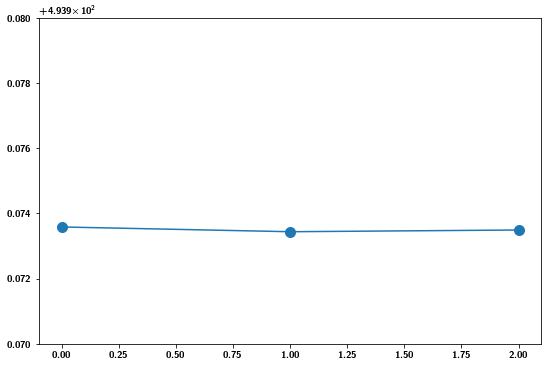

In [140]:
plt.figure(figsize=(9,6))
plt.plot(a.index.values[0:3], a['rmse'].values[0:3], marker='o', markersize=10)
plt.ylim([493.97, 493.98])
plt.show()

In [ ]:
V/m to kV/mm
1 V = 1e-3 kV
1 m = 1e3 mm
factor: 